# **Skin cancer classification using Convolutional Neural Networks**


#### Applied Machine Learning Project (Basic + Advanced)

#### *Student: Gabriele Boscagli (ID: 1076493)*

# **Introduction**

Skin cancer is the most commonly diagnosed form of cancer in humans. It can occur when there is an abnormal growth of skin cells, typically triggered by damage to DNA from ultraviolet (UV) radiation found in sunlight or tanning beds. There are several types of skin cancer, including basal cell carcinoma, squamous cell carcinoma, and melanoma.

In the latest years, Deep Learning (DL) tools such as Artificial Neural Networks (ANNs) have been deployed for the early detection and classification of diseases. Neural networks are able to learn patterns from the given input: texts, graphs, audios and also images, an inestimable source of data when it comes to biology. Convolutional Neural Networks (CNNs) are particularly used for computer vision tasks, included cancer classification.

The dataset ([download link](https://www.kaggle.com/datasets/surajghuwalewala/ham1000-segmentation-and-classification/download?datasetVersionNumber=2)) presented in this project is the HAM10000 dataset ("Human Against Machine with 10000 training images"). This dataset consists of 10015 dermatoscopic images, in "RGB" channel, which can serve as a training set for academic machine learning purposes. Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions:



*   Actinic keratoses and intraepithelial carcinoma / Bowen's disease (***akiec***);
*   Basal cell carcinoma (***bcc***);
*   Benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, ***bkl***);
*   Dermatofibroma (***df***);
*   Melanoma (***mel***);
*   Melanocytic nevi (***nv***);
*   Vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, ***vasc***).

The dataset comes with a single folder for the images (*images*) and a .csv metadata file (*GroundTruth.csv*). Beyond of the project scope is the *masks* folder, containing the segmented images (i.e., the delineation of the tumoral region in the images folder).

The goal of this project is to train a multicategorical CNN classifier able to recognize all the seven cancer types present in the dataset, trying to improve its performance and eventually reduce overfitting.

# Kaggle API download

To use Kaggle data on Colab, follow these steps

1. Go to your Kaggle account, Scroll to API section and Click Expire API Token to remove previous tokens
2. Click on Create New API Token - It will download kaggle.json file on your machine.

In [ ]:
#!pip install -q kaggle

In [1]:
#uploading kaggle.json token

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 72 bytes


# Utility functions

In [17]:
def curve_plot(history):

  '''This function plots the accuracy and loss curves for training and validations sets'''

  fig, axs = plt.subplots(2, 1, figsize=(13, 10))

  # Accuracy curves
  pd.DataFrame(history.history)[["accuracy", "val_accuracy"]].plot(ax=axs[0], color=["blue", "red"])
  axs[0].set_title("Accuracy", fontsize=15, fontweight=600)
  axs[0].legend(labels=["Training", "Validation"])

  # Loss curves
  pd.DataFrame(history.history)[["loss", "val_loss"]].plot(ax=axs[1], color=["blue", "red"])
  axs[1].set_title("Loss", fontsize=15, fontweight=600)
  axs[1].legend(labels=["Training", "Validation"])


def test_prediction(model, test_generator, test_df):

  '''This function predicts the label on the test set, given a model, a test_generator and a dataframe where predictions are stored'''

  pred = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size, verbose=1)
  predicted_class_indices=np.argmax(pred,axis=1) #taking the best shot for every test instance
  labels = (train_generator.class_indices)
  labels = dict((v,k) for k,v in labels.items())
  predictions = [labels[k] for k in predicted_class_indices]

  test_df["predictions"] = predictions #adding the prediction column to the dataframe

  return test_df


def compute_confusion_matrix(test_df):

  '''This function computes the confusion matrix on the test set predictions'''

  y_test = test_df["label"]
  predictions = test_df["predictions"]

  cf_matrix = confusion_matrix(y_true=y_test, y_pred=predictions, normalize="true")

  blue_palette = sns.color_palette("Blues", as_cmap=True)
  plt.figure(figsize=(10, 7))
  sns.heatmap(cf_matrix, annot=True, xticklabels=sorted(set(y_test)), yticklabels=sorted(set(y_test)), cmap=blue_palette, cbar=False)
  plt.title("Confusion Matrix\n", fontsize=20)
  plt.xlabel("Predicted Classes", fontsize=13)
  plt.ylabel("True Classes", fontsize=13)
  plt.xticks(fontsize=10)
  plt.yticks(fontsize=10, rotation=0)
  plt.show()


def image_reallocation(metadata_df):

  '''This function creates the directory architecture needed to train the CNN'''

  IMAGES_PATH = "./images" #path from where the images are taken

  for label in metadata_df['label'].unique():
      '''This for loop creates a subdirectory for each subclass (for training and validation only!)'''
      os.makedirs(os.path.join(train_dir, label), exist_ok=True)
      os.makedirs(os.path.join(val_dir, label), exist_ok=True)

  os.makedirs(test_dir, exist_ok=True) # executed just once for the testing set

  for index, row in metadata_df.iterrows(): # loop through all of the 10015 images

      filename = row["image"]
      label = row["label"]

      #moving image files from ./images directory to the set/label subdirectory
      if filename in X_train.values:
          filename = filename + ".jpg"
          image_path = os.path.join(train_dir, label, filename)
          shutil.move(os.path.join(IMAGES_PATH, filename), image_path)
      elif filename in X_val.values:
          filename = filename + ".jpg"
          shutil.move(os.path.join(IMAGES_PATH, filename), os.path.join(val_dir, label, filename))
      else: #testing
          filename = filename + ".jpg"
          shutil.move(os.path.join(IMAGES_PATH, filename), os.path.join(test_dir, filename))

  print("Training/Validation/Testing split: DONE")


def train_balancing(threshold, transform):

    '''This function rebalances the training set using bootstrap with replacement'''

    base_dir = "./AML_project_Boscagli"
    old_train_dir = os.path.join(base_dir, "train")
    new_train_dir = os.path.join(base_dir, "train_bal") # Classes will be rebalanced on this new directory

    if os.path.isdir(new_train_dir):
        shutil.rmtree(new_train_dir)
    os.mkdir(new_train_dir)

    for subdir in os.listdir(old_train_dir): # loop through every subclass
      train_subdir = os.path.join(old_train_dir, subdir)
      new_train_subdir = os.path.join(new_train_dir, subdir)

      files = os.listdir(train_subdir) # extracting class abundance
      label_df = train_df[train_df["label"] == subdir]["image"].to_numpy()

      if len(files) > threshold: # over-represented classes (just NV)
        os.mkdir(new_train_subdir)
        boot_df = resample(label_df, n_samples=threshold, replace=True)
      else: # under-represented classes
        shutil.copytree(train_subdir, new_train_subdir)  # so that we have all original images in there
        boot_df = resample(label_df, n_samples=threshold-len(files), replace=True) # bootstrapping the remaining images

      for i, filename in enumerate(boot_df):
        source_path = os.path.join(train_subdir, filename + ".jpg")
        dest_path = os.path.join(new_train_subdir, filename + f"_{i}" + ".jpg")
        image = Image.open(source_path)
        image_np = np.array(image)
        augmented = transform(image=image_np) # ...we apply the mild transformations...
        augmented_image = Image.fromarray(augmented["image"])
        augmented_image.save(dest_path) # ...and save the image to train_bal/subdir

      print(f"{subdir} subdir has {len(os.listdir(new_train_subdir))} images")


def print_metrics(test_df):

  '''This function prints some metrics for the test set predictions'''

  test_acc = accuracy_score(test_df["label"], test_df["predictions"])
  test_f1 = f1_score(test_df["label"], test_df["predictions"], average="weighted")
  test_balanced_acc = balanced_accuracy_score(test_df["label"], test_df["predictions"])

  print(f"The test accuracy is {test_acc}")
  print(f"The test F1 score is {test_f1}")
  print(f"The test balanced accuracy is {test_balanced_acc}")

# Dataset download

In [3]:
!kaggle datasets download -d surajghuwalewala/ham1000-segmentation-and-classification

Dataset URL: https://www.kaggle.com/datasets/surajghuwalewala/ham1000-segmentation-and-classification
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
ham1000-segmentation-and-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip "ham1000-segmentation-and-classification.zip"

Output streaming troncato alle ultime 5000 righe.
  inflating: masks/ISIC_0029321_segmentation.png  
  inflating: masks/ISIC_0029322_segmentation.png  
  inflating: masks/ISIC_0029323_segmentation.png  
  inflating: masks/ISIC_0029324_segmentation.png  
  inflating: masks/ISIC_0029325_segmentation.png  
  inflating: masks/ISIC_0029326_segmentation.png  
  inflating: masks/ISIC_0029327_segmentation.png  
  inflating: masks/ISIC_0029328_segmentation.png  
  inflating: masks/ISIC_0029329_segmentation.png  
  inflating: masks/ISIC_0029330_segmentation.png  
  inflating: masks/ISIC_0029331_segmentation.png  
  inflating: masks/ISIC_0029332_segmentation.png  
  inflating: masks/ISIC_0029333_segmentation.png  
  inflating: masks/ISIC_0029334_segmentation.png  
  inflating: masks/ISIC_0029335_segmentation.png  
  inflating: masks/ISIC_0029336_segmentation.png  
  inflating: masks/ISIC_0029337_segmentation.png  
  inflating: masks/ISIC_0029338_segmentation.png  
  inflating: masks/ISIC_0029339_

# Importing libraries

Uncomment the following chunk if the dependencies are not installed.

In [6]:
#!pip install opencv-python
#!pip install -U albumentations

In [5]:
import os
import numpy as np
import pandas as pd
import shutil
import random
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.utils.class_weight import compute_class_weight

from PIL import Image

Once the needed libraries are imported into the notebook, we can read and have a look to the metadata file.

In [6]:
metadata_df = pd.read_csv('./GroundTruth.csv')
print(f'Metadata file has {metadata_df.shape[0]} entries and {metadata_df.shape[1]-1} classes\n') #-1 because we must not count the image id column
metadata_df.head(5)

Metadata file has 10015 entries and 7 classes



image  MEL   NV  BCC  AKIEC  BKL   DF  VASC
0  ISIC_0024306  0.0  1.0  0.0    0.0  0.0  0.0   0.0
1  ISIC_0024307  0.0  1.0  0.0    0.0  0.0  0.0   0.0
2  ISIC_0024308  0.0  1.0  0.0    0.0  0.0  0.0   0.0
3  ISIC_0024309  0.0  1.0  0.0    0.0  0.0  0.0   0.0
4  ISIC_0024310  1.0  0.0  0.0    0.0  0.0  0.0   0.0

As we can see, the metadata file is one-hot encoded: each image reports a 1 under the column representing its label, 0 otherwise. We can restrict the view to only two columns: **id** and **label**.



In [7]:
def get_class_column(row):
    for col in row.index:
        if row[col] == 1.0:
            return col

metadata_df['label'] = metadata_df.apply(get_class_column, axis=1)

metadata_df = metadata_df[['image', 'label']]
metadata_df.head(5)

image label
0  ISIC_0024306    NV
1  ISIC_0024307    NV
2  ISIC_0024308    NV
3  ISIC_0024309    NV
4  ISIC_0024310   MEL

Let's check the abundance of each cancer type in the original dataset.

<Axes: xlabel='Abundance (#)', ylabel='Label'>

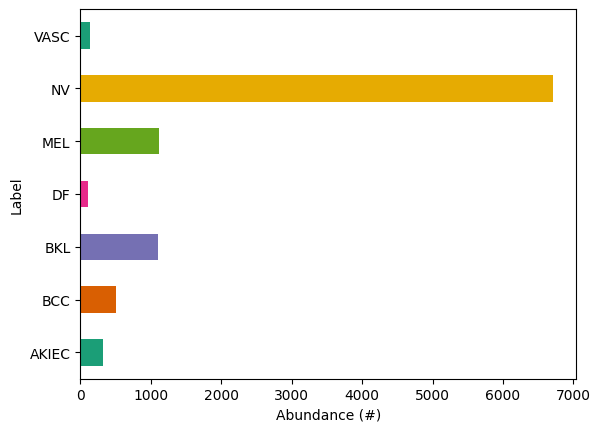

In [8]:
metadata_df.groupby("label").size().plot(kind='barh', xlabel = "Abundance (#)", ylabel = "Label", color=sns.palettes.mpl_palette('Dark2'))

In [9]:
metadata_df.groupby('label').size()

label
AKIEC     327
BCC       514
BKL      1099
DF        115
MEL      1113
NV       6705
VASC      142
dtype: int64

It is immediately clear that there is an imbalance in the dataset: the NV class is overrepresented, with 6.705 of the 10.015 total entries. For now, we will keep the frequency as it is.

# Training/Validation/Testing split

One of the prerequisites of the CNN model construction is the splitting of the original dataset in training, validation and testing. It is of crucial importance to organize the image files already divided by set and subclass prior to the training.

In [10]:
X = metadata_df["image"]
y = metadata_df["label"]

TEST_SPLIT = 0.1 # fraction of the total set allocated for the testing procedure
VALID_SPLIT = 0.2 # fraction of the training set allocated for the validation

base_dir = "./AML_project_Boscagli"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test/test_images")

labels = sorted(metadata_df["label"].unique())

The splitting is performed with `train_test_split` function by `sklearn`, stratifying by the labels in order to have an equal distribution of images of each type in all the sets. I allocated ≈ 72% of images to the training, 18% for the validation and 10% for the testing.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SPLIT, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=VALID_SPLIT, random_state=42, stratify=y_train)

print(f"The training set has {X_train.shape[0]} images")
print(f"The validation set has {X_val.shape[0]} images")
print(f"The testing set has {X_test.shape[0]} images")

The training set has 7210 images
The validation set has 1803 images
The testing set has 1002 images


In [15]:
train_df = metadata_df[metadata_df["image"].isin(X_train)]
val_df = metadata_df[metadata_df["image"].isin(X_val)]
test_df = metadata_df[metadata_df["image"].isin(X_test)]

By now, we only have the image IDs for training, validation and testing in three different arrays, but the image files are still in the same folder. The reallocation is performed leveraging the `os` package.

In [12]:
image_reallocation(metadata_df)

Training/Validation/Testing split: DONE


Uncomment and run the following line of code to send all the images back to the original directory.

In [ ]:
#!mv ./AML_project_Boscagli/*/*/*.jpg ./images

# Plotting some examples from each class

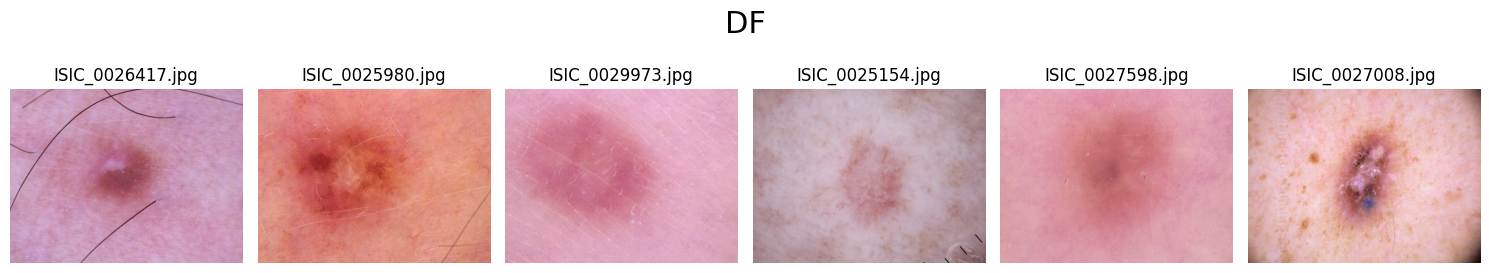

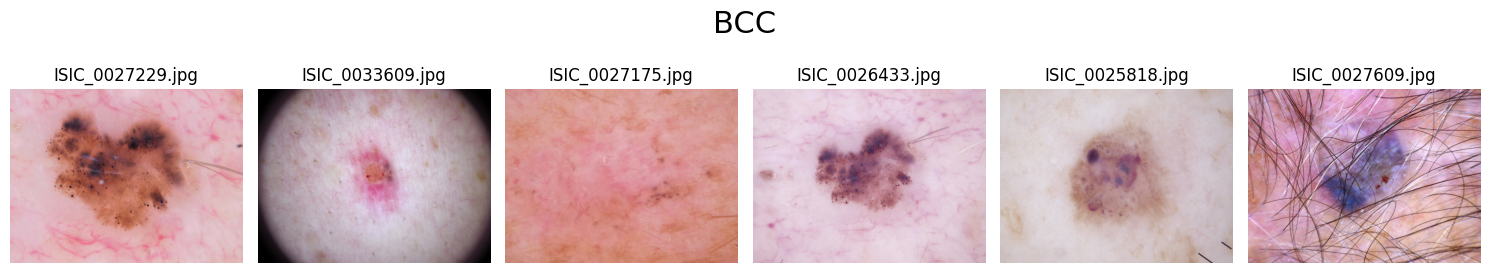

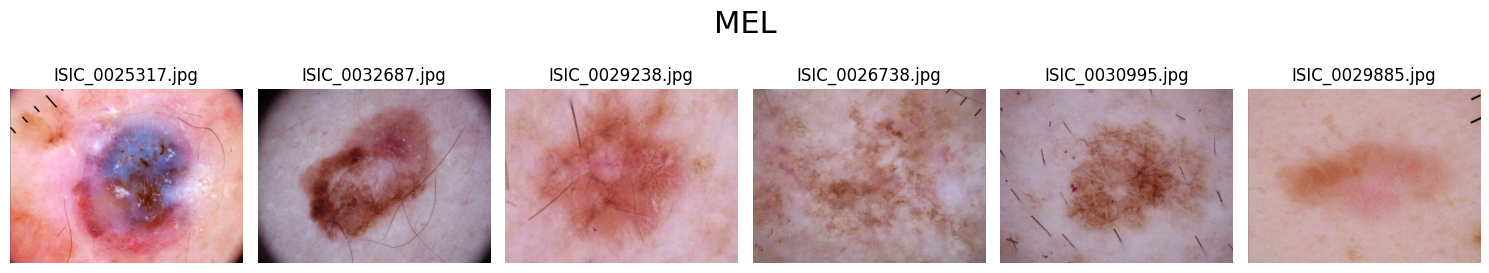

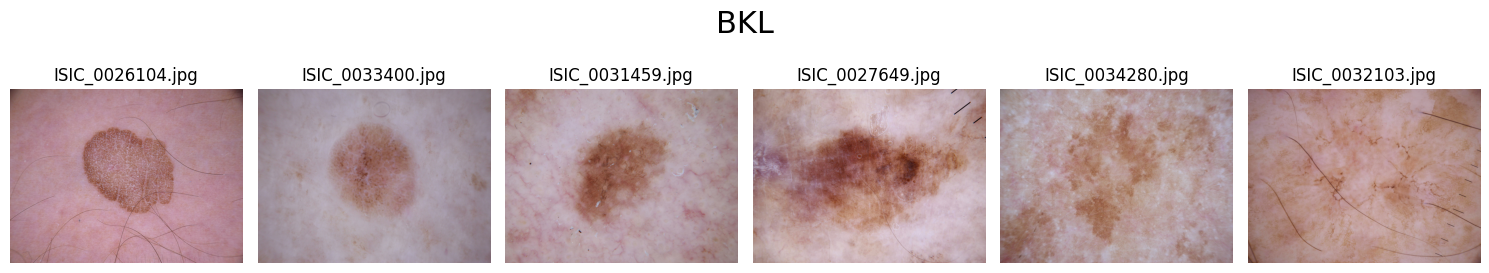

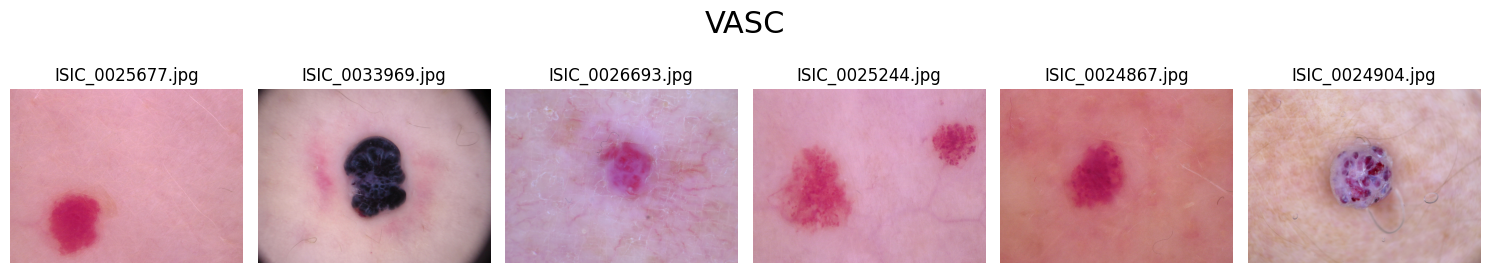

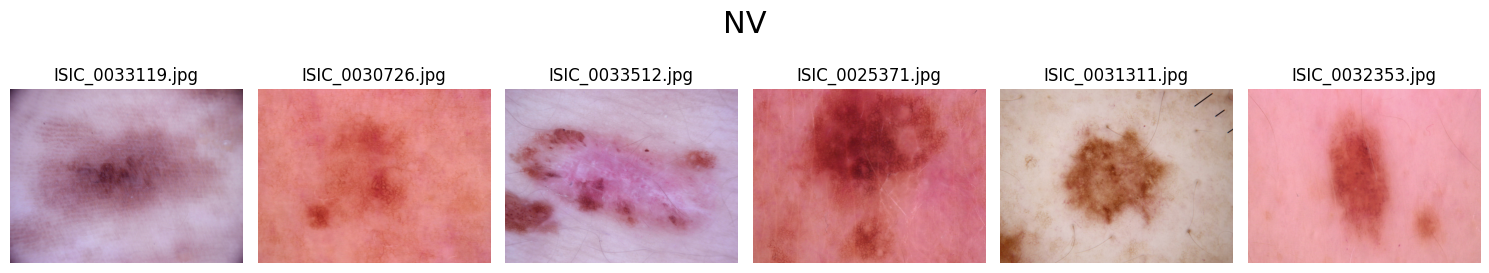

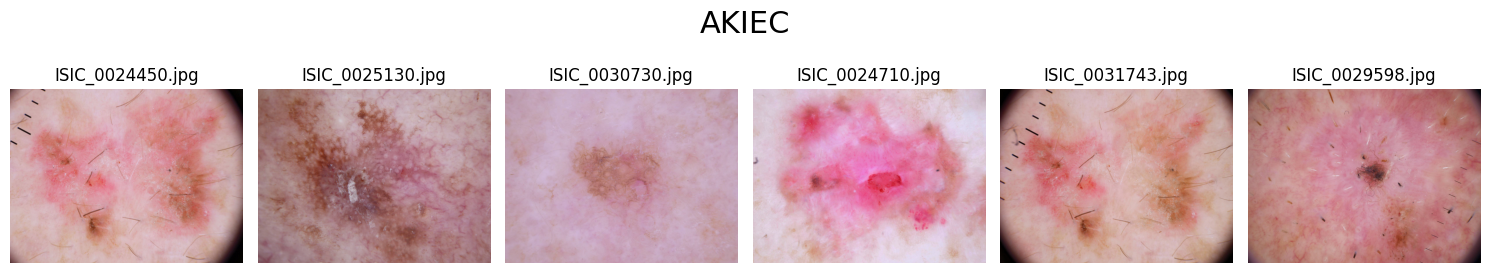

In [13]:
for subdir in os.listdir(train_dir): #for every class...
  dir_path = os.path.join(train_dir, subdir)
  imgs_to_plot = os.listdir(dir_path)[:6] #...six images
  plt.figure(figsize=(15, 3))
  plt.suptitle(subdir, fontsize=22)
  columns = 3
  for i, image in enumerate(imgs_to_plot):
    image_path = os.path.join(dir_path, image)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, len(imgs_to_plot), i+1)
    plt.imshow(img)
    plt.title(image)
    plt.axis('off')

  plt.tight_layout()
  plt.show()
  print()

# Model construction

Now that we have a proper file organization, we can move on to the model preparation. We take advantage of the `Keras`' `ImageDataGenerator` class, that generates on-the-fly batches of tensor image data with real-time data augmentation. The generators can also be used as input of the fit function.

In [17]:
train_gen = ImageDataGenerator(rescale=1./255)
validation_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_directory(
    "./AML_project_Boscagli/train",
    target_size=(120, 160),  # The image size
    batch_size=32, # The number of batches with which the training set is divided
    class_mode='categorical') # Appropriate for multi-class datasets

validation_generator = validation_gen.flow_from_directory(
    "./AML_project_Boscagli/val",
    target_size=(120, 160),
    batch_size=32,
    class_mode='categorical')

test_generator = test_gen.flow_from_directory(
    "./AML_project_Boscagli/test",
    target_size=(120, 160),
    batch_size=1, # 1 because we want all the entries to be evaluated
    class_mode='categorical',
    shuffle=False)  # To keep the order of images intact for evaluation (useful for subsequent mapping of labels)

Found 7210 images belonging to 7 classes.
Found 1803 images belonging to 7 classes.
Found 1002 images belonging to 1 classes.


Now we can initialize our first Convolutional Neural Network. It consists of:

*   three pairs of `Conv2D`+`MaxPooling2D` layers, with input size (120, 160, 3), respectively height, width and color channels (RGB);
*   a `Flatten` layer, used to flat the 3D feature maps into a 1D vector;
*   a hidden `Dense` layer with 512 neurons;
*   a `Dense` output layer of size 7, that is the number of classes the model must predict.

The model is then compiled with `Adam` optimizer and with `categorical_crossentropy` loss function.

In [18]:
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(120, 160, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation="relu"),
    Dense(len(labels), activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 158, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 59, 79, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 77, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 28, 38, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 36, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 18, 128)       0

In [19]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size)

Epoch 1/10
225/225 [==============================] - 74s 304ms/step - loss: 0.9982 - accuracy: 0.6655 - val_loss: 0.9080 - val_accuracy: 0.6786
Epoch 2/10
225/225 [==============================] - 67s 298ms/step - loss: 0.8739 - accuracy: 0.6899 - val_loss: 0.7953 - val_accuracy: 0.7054
Epoch 3/10
225/225 [==============================] - 58s 260ms/step - loss: 0.8082 - accuracy: 0.7079 - val_loss: 0.7711 - val_accuracy: 0.7199
Epoch 4/10
225/225 [==============================] - 67s 300ms/step - loss: 0.7338 - accuracy: 0.7254 - val_loss: 0.7717 - val_accuracy: 0.7372
Epoch 5/10
225/225 [==============================] - 68s 301ms/step - loss: 0.6728 - accuracy: 0.7494 - val_loss: 0.7193 - val_accuracy: 0.7405
Epoch 6/10
225/225 [==============================] - 67s 299ms/step - loss: 0.6421 - accuracy: 0.7650 - val_loss: 0.7351 - val_accuracy: 0.7299
Epoch 7/10
225/225 [==============================] - 59s 263ms/step - loss: 0.5588 - accuracy: 0.7917 - val_loss: 0.7606 - val_ac

This mock model achieved a remarkable 0.86 accuracy on the training set, but the trend on the validation set is way worse: there is no learning over the 10 epochs! What is going on? There is room for improvement, for sure.

# Model evaluation

Once the model has been trained, it's time to use it to predict the labels on the test set. The `pred` variable contains, for each test entry, the probability of belonging to a certain label. We can extract the model prediction using `Numpy` argmax and then map the numerical label to the categorical one.

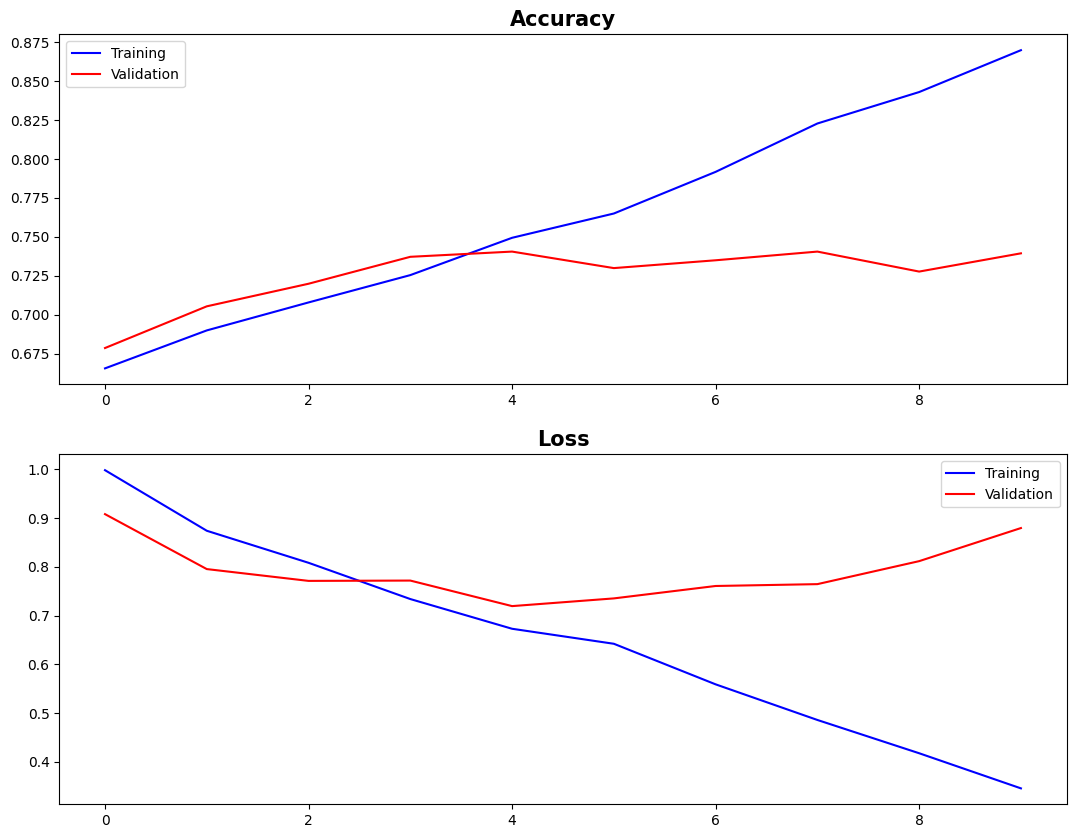

In [20]:
curve_plot(history)

In [21]:
metadata_df_test = test_prediction(model, test_generator, test_df)

1002/1002 [==============================] - 7s 7ms/step


<ipython-input-3-2c4130cf5ebf>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["predictions"] = predictions #adding the prediction column to the dataframe


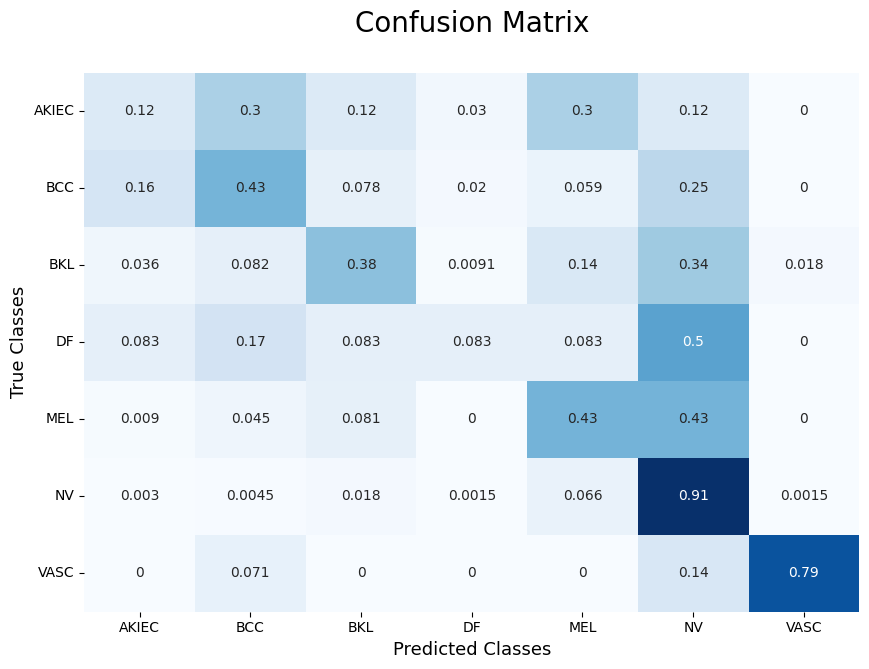

In [22]:
compute_confusion_matrix(metadata_df_test)

In [23]:
print_metrics(test_df)

The test accuracy is 0.7345309381237525
The test F1 score is 0.7218627701060539
The test balanced accuracy is 0.44885616952706087


As we can see, the model performance is strongly impaired by the NV sample abundance in the dataset. The model has been clearly trained to recognize NV samples and thus predicts NV even when the tumor type is different. The other six types of cancer are predicted NV-positive in a range of 12-55% of the times.

The test balanced accuracy is way more informative when dealing with imbalanced datasets: it gives equal weight to each class, regardless of its size. While the test accuracy is well above 70%, the test balanced accuracy is around 45%.

# Refining the model

Is there some way to improve the prediction capabilities of the CNN? We now tackle the problem of the class imbalance by introducing the `compute_class_weight` function of sklearn.

In [42]:
train_gen = ImageDataGenerator(rescale=1./255)
validation_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_directory(
    "./AML_project_Boscagli/train",
    target_size=(120, 160),
    batch_size=32,
    class_mode='categorical')

validation_generator = validation_gen.flow_from_directory(
    "./AML_project_Boscagli/val",
    target_size=(120, 160),
    batch_size=32,
    class_mode='categorical')

test_generator = test_gen.flow_from_directory(
    "./AML_project_Boscagli/test",
    target_size=(120, 160),
    batch_size=1,
    class_mode='categorical',
    shuffle=False)

Found 7210 images belonging to 7 classes.
Found 1803 images belonging to 7 classes.
Found 1002 images belonging to 1 classes.


The `compute_class_weight` function of sklearn assigns a weight to each class, based on the class abundance. This way, the instances of the overrepresented classes count less, while the instances of the under-represented classes count more.

In [25]:
class_weights = compute_class_weight(class_weight = "balanced", classes = np.unique(y_train), y = y_train)
num_list = [0, 1, 2, 3, 4, 5, 6]
label_to_num_dict = {label:num for label, num in zip(np.unique(y_train), num_list)}
class_weights = {label:weight for label, weight in zip(num_list, class_weights)} # the fit model only accepts numerical labels

print(label_to_num_dict)
print(class_weights)

{'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}
{0: 4.382978723404255, 1: 2.7837837837837838, 2: 1.302149178255373, 3: 12.409638554216867, 4: 1.28428927680798, 5: 0.21338305365651544, 6: 10.098039215686274}


We also add an feature to the model, as the `Dropout`. The Dropout randomly deactivates some neurons, thus decrementing the reliance of the model to specific neurons. Finally, we increment the number of epochs from 10 to 20.

In [26]:
model_2 = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(120, 160, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation="relu"),
    Dense(len(metadata_df["label"].unique()), activation="softmax")
])

lr_scheduler = ReduceLROnPlateau(factor=0.3, patience=3, min_lr=0.0001)

model_2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 118, 158, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 59, 79, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 57, 77, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 28, 38, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 26, 36, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 13, 18, 128)      

In [43]:
history_2 = model_2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[lr_scheduler],
    class_weight=class_weights)

Epoch 1/20
225/225 [==============================] - 70s 310ms/step - loss: 1.1565 - accuracy: 0.5109 - val_loss: 1.1669 - val_accuracy: 0.5100 - lr: 3.0000e-04
Epoch 2/20
225/225 [==============================] - 84s 374ms/step - loss: 0.9992 - accuracy: 0.5825 - val_loss: 1.0404 - val_accuracy: 0.5603 - lr: 3.0000e-04
Epoch 3/20
225/225 [==============================] - 61s 272ms/step - loss: 0.9034 - accuracy: 0.6099 - val_loss: 1.1035 - val_accuracy: 0.5497 - lr: 3.0000e-04
Epoch 4/20
225/225 [==============================] - 67s 299ms/step - loss: 0.8501 - accuracy: 0.6264 - val_loss: 1.1085 - val_accuracy: 0.5670 - lr: 3.0000e-04
Epoch 5/20
225/225 [==============================] - 67s 300ms/step - loss: 0.8003 - accuracy: 0.6415 - val_loss: 1.0177 - val_accuracy: 0.6122 - lr: 3.0000e-04
Epoch 6/20
225/225 [==============================] - 59s 261ms/step - loss: 0.7487 - accuracy: 0.6553 - val_loss: 1.0126 - val_accuracy: 0.6155 - lr: 3.0000e-04
Epoch 7/20
225/225 [========

While the trend on training set is encouraging, the validation loss and accuracy curves remain flat. Let's have a look at the confusion matrix.

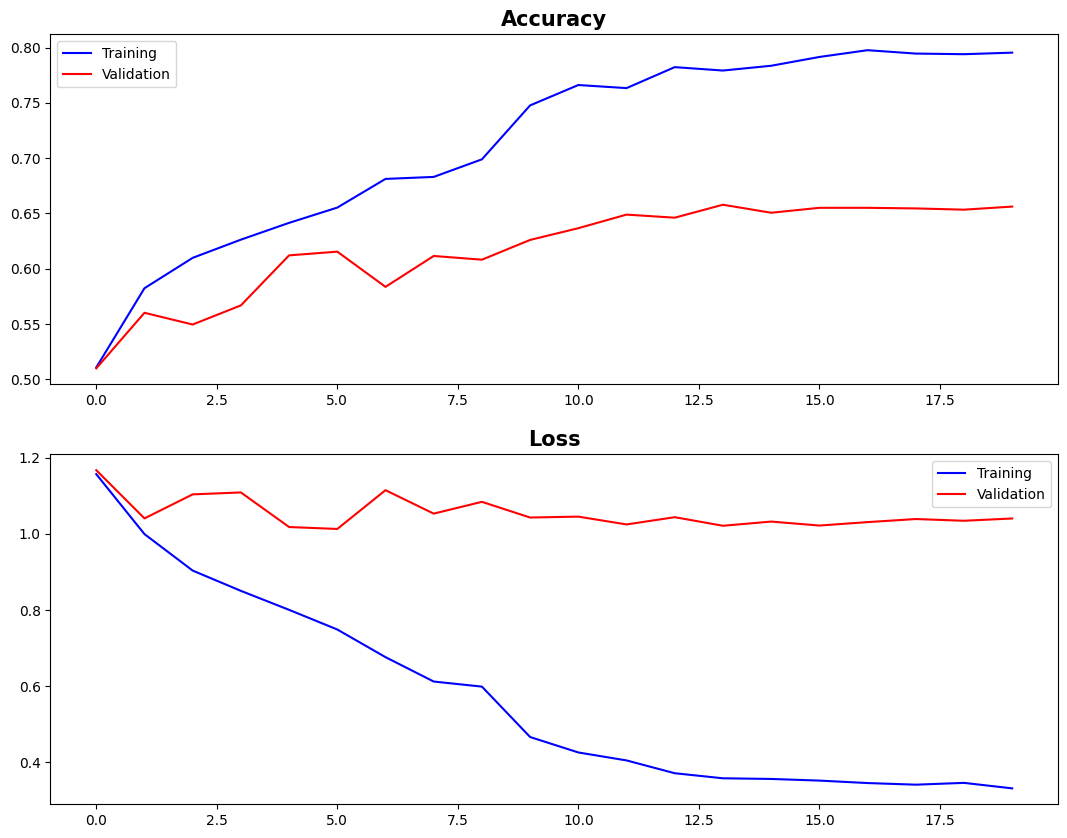

In [44]:
curve_plot(history_2)

In [45]:
test_generator.reset()
test_df = test_prediction(model_2, test_generator, test_df)

1002/1002 [==============================] - 8s 8ms/step


<ipython-input-3-2c4130cf5ebf>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["predictions"] = predictions #adding the prediction column to the dataframe


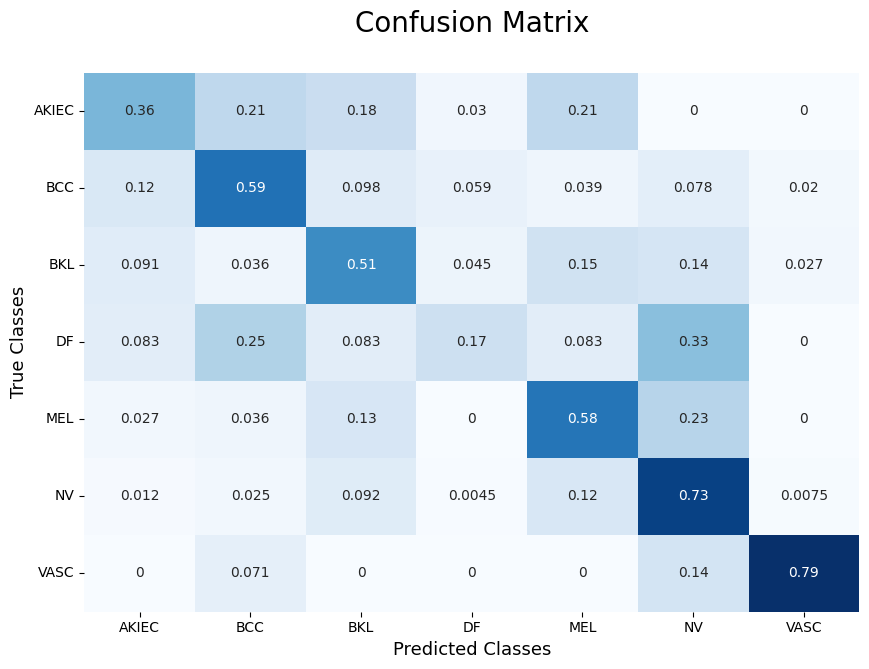

In [46]:
compute_confusion_matrix(test_df)

In [47]:
print_metrics(test_df)

The test accuracy is 0.6666666666666666
The test F1 score is 0.6894175593089067
The test balanced accuracy is 0.5320920554148272


It seems that the weights returned by `compute_class_weight` are just bad for the task. The test balanced accuracy is slightly better than the one returned by the first model, but it's still unsatisfying.

We now try to balance the dataset at the image level. Also, we can further increase the number of epochs from 20 to 30.

# Refining the model (again)

The main problem behind the second model was the strength of the weights. We now balance the dataset at the image level: each class will now have 2000 images. We perform bootstrapping with replacement, applying some mild data augmentation prior to those granted by `ImageDataGenerator` in order to simulate having new data.

In [18]:
transform = A.Compose([
    A.GaussianBlur(p=0.75),
    A.PixelDropout(dropout_prob=0.01, p=0.75),
    A.VerticalFlip(p=0.75),
    A.OpticalDistortion(distort_limit=(-0.1, 0.1), p=0.75)
])

samples_per_class = 2000
train_balancing(samples_per_class, transform)

DF subdir has 2000 images
BCC subdir has 2000 images
MEL subdir has 2000 images
BKL subdir has 2000 images
VASC subdir has 2000 images
NV subdir has 2000 images
AKIEC subdir has 2000 images


In [19]:
train_gen = ImageDataGenerator(rescale=1./255,
                               zoom_range=(0.75, 1.25),   # zooming in or out on the images randomly
                               rotation_range=50, # rotating images (angles)
                               shear_range=0.2, # distorting the images
                               width_shift_range=0.2, # shifting the images horizontally by a fraction of the image width
                               height_shift_range=0.2, # shifting the images vertically by a fraction of the image height
                               channel_shift_range=0.2,
                               horizontal_flip=True,
                               brightness_range=(0.75, 1.25),
                               fill_mode="nearest"
                               )

validation_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_directory(
    "./AML_project_Boscagli/train_bal", # The training directory is now different
    target_size=(120, 160),
    batch_size=64,
    class_mode='categorical')

validation_generator = validation_gen.flow_from_directory(
    "./AML_project_Boscagli/val",
    target_size=(120, 160),
    batch_size=32,
    class_mode='categorical')

test_generator = test_gen.flow_from_directory(
    "./AML_project_Boscagli/test",
    target_size=(120, 160),
    batch_size=1,
    class_mode='categorical',
    shuffle=False)

Found 14000 images belonging to 7 classes.
Found 1803 images belonging to 7 classes.
Found 1002 images belonging to 1 classes.


In [22]:
model_3 = Sequential([
    Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(120, 160, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    Flatten(),

    BatchNormalization(),
    Dense(512, activation="relu"),
    Dropout(0.25),
    Dense(len(labels), activation="softmax")
])

lr_scheduler = ReduceLROnPlateau(factor=0.3, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor="accuracy", patience=5)

model_3.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model_3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 120, 160, 32)      896       
                                                                 
 batch_normalization_2 (Bat  (None, 120, 160, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 60, 80, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 80, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 30, 40, 64)        0         
 g2D)                                                            
                                                      

In [23]:
history_3 = model_3.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[lr_scheduler, early_stopping]
    )

Epoch 1/30
218/218 [==============================] - 144s 644ms/step - loss: 1.7477 - accuracy: 0.3979 - val_loss: 3.6106 - val_accuracy: 0.0843 - lr: 0.0010
Epoch 2/30
218/218 [==============================] - 148s 676ms/step - loss: 1.3045 - accuracy: 0.5006 - val_loss: 2.1726 - val_accuracy: 0.2400 - lr: 0.0010
Epoch 3/30
218/218 [==============================] - 139s 636ms/step - loss: 1.1823 - accuracy: 0.5463 - val_loss: 1.3836 - val_accuracy: 0.4955 - lr: 0.0010
Epoch 4/30
218/218 [==============================] - 141s 647ms/step - loss: 1.1151 - accuracy: 0.5697 - val_loss: 1.3481 - val_accuracy: 0.5446 - lr: 0.0010
Epoch 5/30
218/218 [==============================] - 139s 639ms/step - loss: 1.0481 - accuracy: 0.5934 - val_loss: 1.3905 - val_accuracy: 0.4643 - lr: 0.0010
Epoch 6/30
218/218 [==============================] - 143s 658ms/step - loss: 1.0160 - accuracy: 0.6131 - val_loss: 1.7914 - val_accuracy: 0.4833 - lr: 0.0010
Epoch 7/30
218/218 [==========================

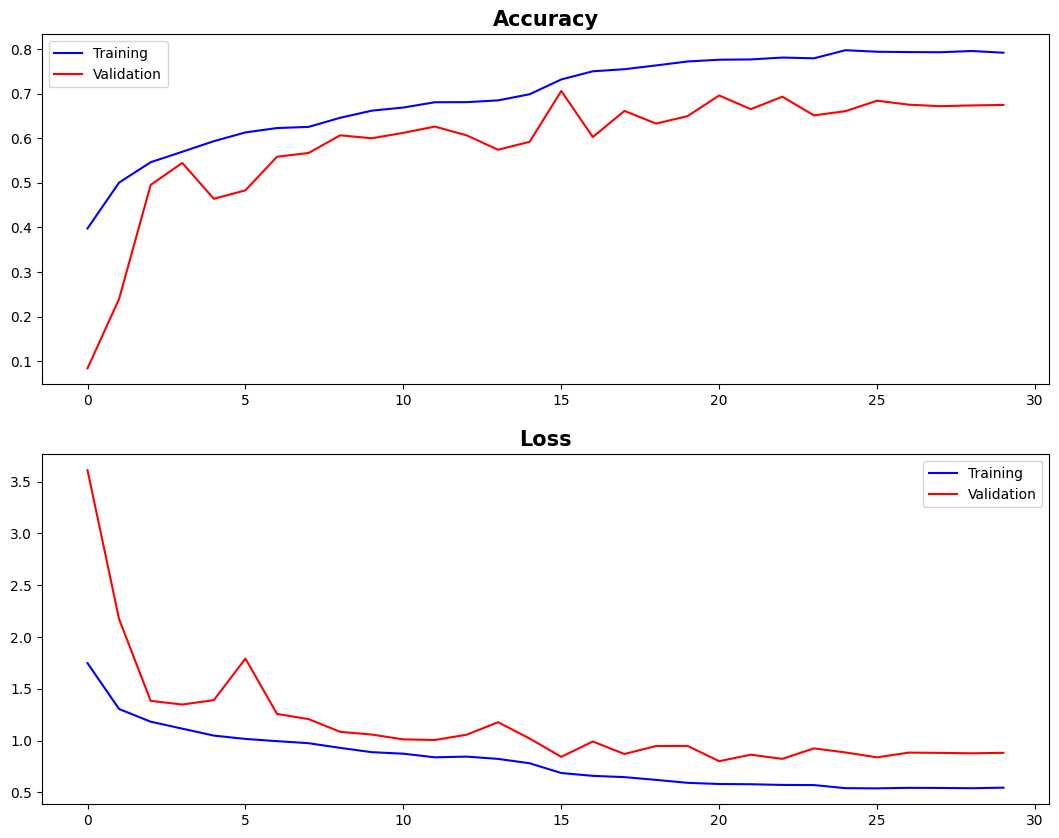

In [24]:
curve_plot(history_3)

In [25]:
test_generator.reset()
test_df = test_prediction(model_3, test_generator, test_df)

1002/1002 [==============================] - 10s 9ms/step


<ipython-input-17-ff380172ba28>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["predictions"] = predictions #adding the prediction column to the dataframe


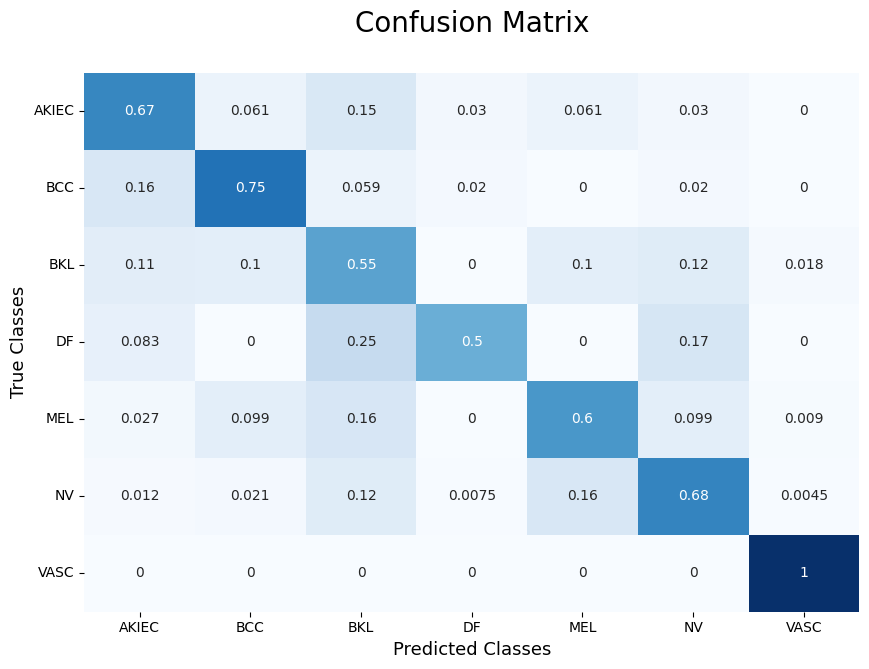

In [26]:
compute_confusion_matrix(test_df)

In [27]:
print_metrics(test_df)

The test accuracy is 0.6616766467065869
The test F1 score is 0.6902524100280316
The test balanced accuracy is 0.6782865947764695


The learning rate reduction granted by `ReduceLROnPlateau` makes the validation accuracy and loss curves less prone to ups and downs.
The latter results are encouraging, even if the discrepancy between training accuracy (79%) and validation accuracy (67%) isn't negligible. The model is now more capable of generalization, as we can see by the test accuracy (66%) and test balanced accuracy (68%) that are very similar.